### **1** - Descompactando pasta com arquivos de dados

In [ ]:
!unzip /content/dataset-skincancer.zip

### **2** - Carregando as Bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
import cv2
import random
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

from keras.layers import Conv2D
from keras.layers import MaxPooling2D

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, accuracy_score

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


### **3** - Carregando o Dataset

In [ ]:
data = pd.read_csv('/content/dataset-skincancer/HAM10000_metadata.csv')

### **4** - Explorando o Dataset

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
data.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [ ]:
data.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
data.shape

(10015, 7)

### **5** - Buscando pixels das imagens

In [ ]:
data = pd.read_csv('/content/dataset-skincancer/hmnist_28_28_RGB.csv')
data[0:3]

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2


### **6** - Analisando dados das imagens

In [ ]:
n=len(data)
print(n)

10015


In [ ]:
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

In [ ]:
Data = data.iloc[:,0:-1]
Label = data.iloc[:,-1]

In [ ]:
Label.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [ ]:
X=Data.iloc[N[0:(n//10)*8],:]
y0=Label[N[0:(n//10)*8]]

test=Data.iloc[N[(n//10)*8:],:]
test_label=Label[N[(n//10)*8:]]

In [ ]:
binencoder = LabelBinarizer()
y = binencoder.fit_transform(y0)
y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
X_images = X.values.reshape(-1,28,28,3)
test_images = test.values.reshape(-1,28,28,3)

print(X_images.shape)
print(test_images.shape)

(8008, 28, 28, 3)
(2007, 28, 28, 3)


### **7** - Exibindo as imagens disponíveis no dataset

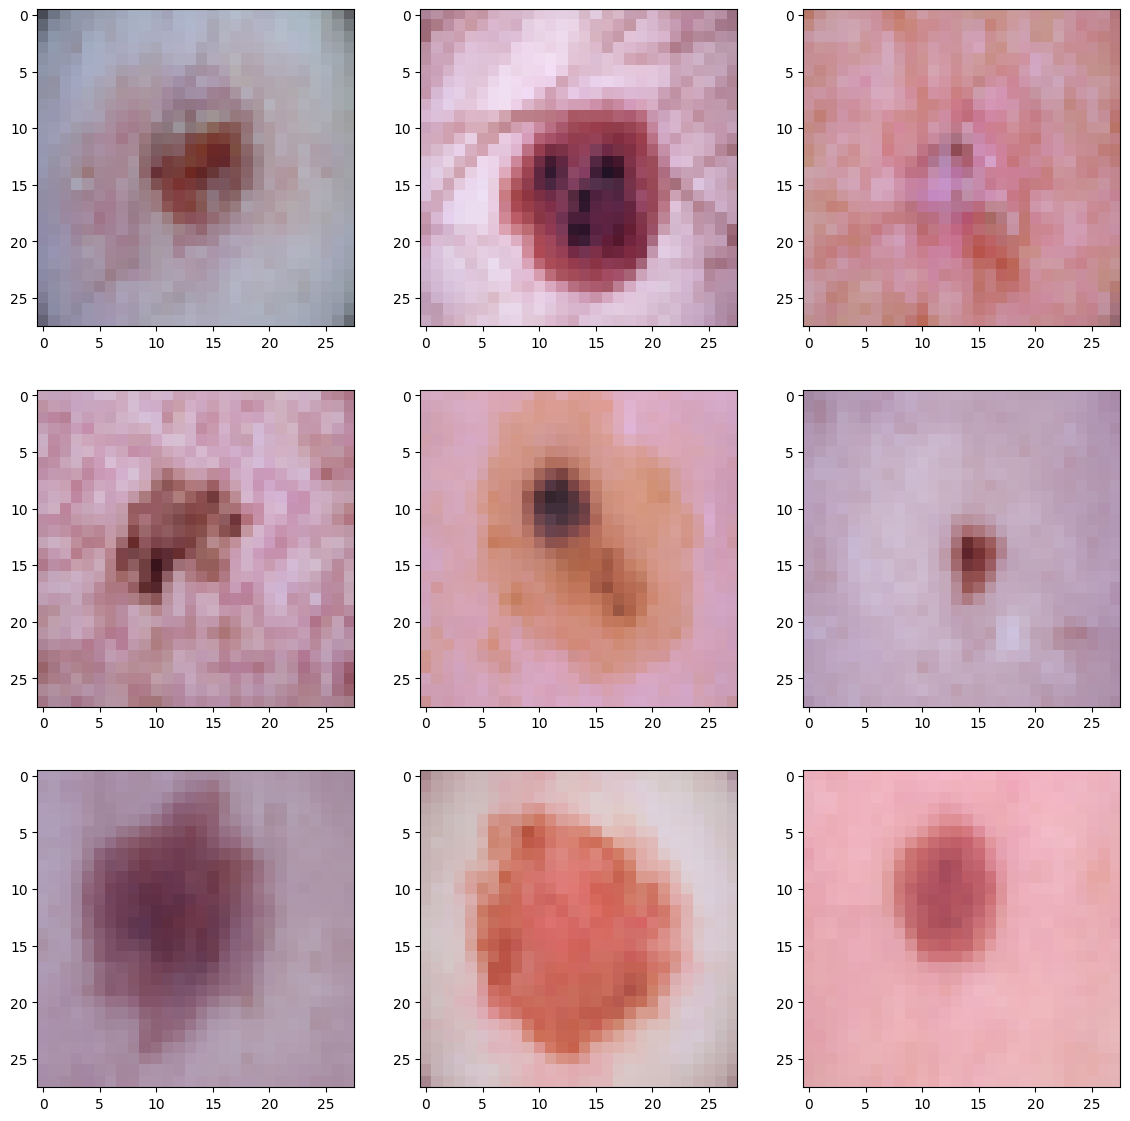

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(14,14))
for i in range(9):
    r=i//3
    c=i%3
    ax=axs[r][c].imshow(X_images[i])
plt.show()

### **8** - Separando o dataset para treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size = 0.2, random_state=90)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6406, 28, 28, 3)
(1602, 28, 28, 3)
(6406, 7)
(1602, 7)


In [ ]:
X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(-1,28,28,3).astype('float32')
X_test = X_test.reshape(-1,28,28,3).astype('float32')

In [ ]:
test_images2 = test_images/255
test = test_images2.reshape(-1,28,28,3).astype('float32')

### **9** - Criando o modelo

In [ ]:
model = Sequential()

model.add(Conv2D(128,(2,2),input_shape = (28,28,3),activation = 'relu'))
model.add(Conv2D(128,(2,2),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 128)       1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 128)       65664     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dropout (Dropout)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 128)               2769024   
                                                        

### **10** - Treinando o modelo

In [ ]:
result = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=92, verbose=2)

Epoch 1/50
56/56 - 29s - loss: 1.0646 - accuracy: 0.6610 - val_loss: 0.9629 - val_accuracy: 0.6685 - 29s/epoch - 518ms/step
Epoch 2/50
56/56 - 28s - loss: 0.9007 - accuracy: 0.6778 - val_loss: 0.8382 - val_accuracy: 0.6958 - 28s/epoch - 496ms/step
Epoch 3/50
56/56 - 28s - loss: 0.8291 - accuracy: 0.7045 - val_loss: 0.8024 - val_accuracy: 0.7051 - 28s/epoch - 492ms/step
Epoch 4/50
56/56 - 28s - loss: 0.7824 - accuracy: 0.7184 - val_loss: 0.8048 - val_accuracy: 0.7059 - 28s/epoch - 491ms/step
Epoch 5/50
56/56 - 28s - loss: 0.7605 - accuracy: 0.7207 - val_loss: 0.8575 - val_accuracy: 0.6903 - 28s/epoch - 493ms/step
Epoch 6/50
56/56 - 28s - loss: 0.7295 - accuracy: 0.7283 - val_loss: 0.7853 - val_accuracy: 0.7200 - 28s/epoch - 506ms/step
Epoch 7/50
56/56 - 27s - loss: 0.6842 - accuracy: 0.7465 - val_loss: 0.7682 - val_accuracy: 0.6880 - 27s/epoch - 489ms/step
Epoch 8/50
56/56 - 28s - loss: 0.6407 - accuracy: 0.7662 - val_loss: 0.7300 - val_accuracy: 0.7356 - 28s/epoch - 492ms/step
Epoch 9/

In [ ]:
model.save("modelo.keras")

### **11** - Plotando gráficos de perda e acurácia

<Axes: >

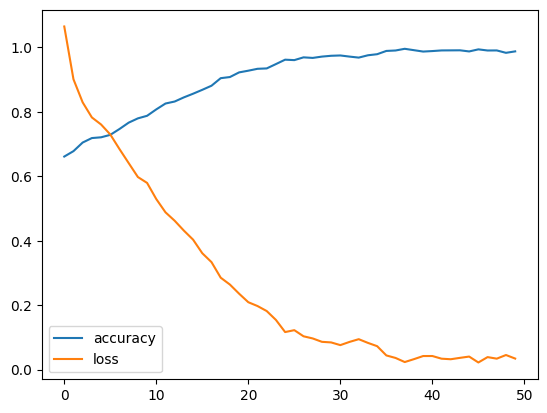

In [ ]:
history_df = pd.DataFrame(result.history)
history_df.loc[:,['accuracy','loss']].plot()

### **12** - Calculando o valor de previsão do modelo

In [ ]:
y_pred = model.predict(test)
print(y_pred[0])

63/63 [==============================] - 3s 40ms/step
[3.5350745e-13 3.5608458e-12 4.0146948e-11 1.5313450e-13 9.9999994e-01
 9.8410634e-15 6.3924690e-13]


In [ ]:
PRED=[]
for item in y_pred:
    value2=np.argmax(item)
    PRED+=[value2]
print(PRED[0])

4


In [ ]:
ANS=test_label
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.6870951669157948


### **13** - Teste da acuracia com uma das imagens do **banco**

#### **13.1** - Carrega o modelo pré-treinado

In [ ]:
model = load_model("modelo.keras")

#### **13.2** - Mapear índices das classes de acordo com os labels

In [ ]:
class_labels = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses'
}

#### **13.3** - Função para processar a imagem

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    img = np.reshape(img, (1, 28, 28, 3))
    return img

#### **13.4** - Função para prever a classe da imagem definida

In [ ]:
def predict_image_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction)
    print(prediction)
    return predicted_class

#### **13.5** - Função para exibir a imagem

In [ ]:
def display_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### **13.6** - Teste do programa

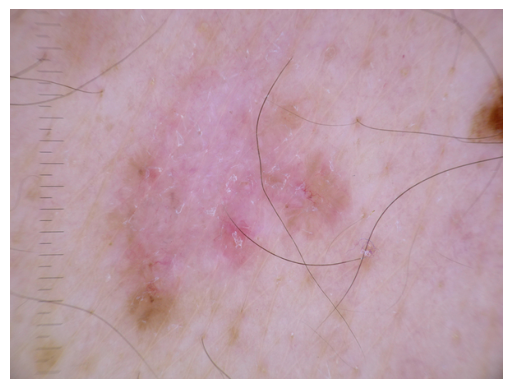

1/1 [==============================] - 0s 19ms/step
[[2.9448140e-03 2.0653432e-02 1.2720790e-02 9.6296769e-01 7.8890094e-05
  8.7633722e-05 5.4678024e-04]]
The predicted class is: 3 - Basal cell carcinoma


In [ ]:
image_path = '/content/dataset-skincancer/Imagens/ISIC_0024673.jpg'
display_image(image_path)
predicted_class = predict_image_class(image_path, model)
predicted_label = class_labels[predicted_class]
print(f"The predicted class is: {predicted_class} - {predicted_label}")